In [1]:
!pip install imblearn

     |████████████████████████████████| 206 kB 15.9 MB/s eta 0:00:01
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrade pip' command.


In [22]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt 
import seaborn as sns

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import time

# Classifiers
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import SGDClassifier

from sklearn.model_selection import RepeatedStratifiedKFold

from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, classification_report
from sklearn.metrics import plot_confusion_matrix
from imblearn.pipeline import make_pipeline

from imblearn.under_sampling import EditedNearestNeighbours
from imblearn.over_sampling import SMOTE, RandomOverSampler, ADASYN

%matplotlib inline

import sys
sys.path.append("..")
from CustomTransformer import CustomTransformer

from numpy import mean
from numpy import std
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import StackingClassifier

from imblearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from imblearn.pipeline import make_pipeline

In [40]:
import os 
os.chdir("../")
bucket = 'aws-project-politomaster-sagemaker-data' 

# Import the pre-processed datasets

In [41]:
prep_train_path = os.path.join('s3://', bucket, 'preprocess/prep_train.csv')
prep_train = pd.read_csv(prep_train_path)
print("Prep_train dataset has: {} rows and {} columns".format(prep_train.shape[0], prep_train.shape[1]))
prep_train.head()

Prep_train dataset has: 43170 rows and 10 columns


,carat_class,cut,color,clarity,depth,table,price,x,y,z
0,0,4,5,1,61.746807,54.834605,651.357414,5.350743,4.352193,2.667488
1,0,3,5,2,60.811398,60.300733,651.357414,5.350743,4.352193,2.667488
2,0,1,5,4,59.799569,60.300733,651.357414,5.350743,4.352193,2.667488
3,0,3,1,3,62.110048,57.770527,651.357414,5.350743,4.352193,2.667488
4,0,1,0,1,63.367713,58.202601,651.357414,5.350743,4.352193,2.899670


In [42]:
prep_test_path = os.path.join('s3://', bucket, 'preprocess/prep_test.csv')
prep_test = pd.read_csv(prep_test_path)
print("Prep_test dataset has: {} rows and {} columns".format(prep_test.shape[0], prep_test.shape[1]))
prep_train.head()

Prep_test dataset has: 10770 rows and 10 columns


,carat_class,cut,color,clarity,depth,table,price,x,y,z
0,0,4,5,1,61.746807,54.834605,651.357414,5.350743,4.352193,2.667488
1,0,3,5,2,60.811398,60.300733,651.357414,5.350743,4.352193,2.667488
2,0,1,5,4,59.799569,60.300733,651.357414,5.350743,4.352193,2.667488
3,0,3,1,3,62.110048,57.770527,651.357414,5.350743,4.352193,2.667488
4,0,1,0,1,63.367713,58.202601,651.357414,5.350743,4.352193,2.899670


# Split the training set into train and validation

In [43]:
seed = 0

target = prep_train['carat_class']
data = prep_train.drop(labels = ['carat_class'],axis = 1)
sample_train, sample_val, label_train, label_val = \
    train_test_split(data, target, test_size=0.3, random_state=seed)

# Define some simple test models

In [44]:
def get_models():
    models = dict()
    models['knn'] = KNeighborsClassifier()
    models['dtc'] = DecisionTreeClassifier()
    models['svm'] = SVC(gamma='auto',kernel='rbf', C = 1.0, random_state = seed)
    return models

# Define an evaluation metric

In [45]:
def evaluate_model(model, sample_train, label_train, sample_val, label_val ):
    model.fit(sample_train, label_train)
    pred = model.predict(sample_val)
    report = classification_report(label_val,pred, output_dict = True)
    scores = report['accuracy']
    return scores

In [46]:
custom_transf = CustomTransformer()
std_scale = StandardScaler()
pca = PCA(n_components=8)
enn = EditedNearestNeighbours()

# Evaluate models

In [48]:
# get the models to evaluate
models = get_models()
# evaluate the models and store results
results, names = list(), list()

for name, model in models.items():
    model_pipe = make_pipeline(custom_transf,std_scale,pca,enn,model)
    scores = evaluate_model(model_pipe, sample_train, label_train,  sample_val, label_val)
    results.append(scores)
    names.append(name)
    print('>%s %.6f' % (name, (scores)))

>knn 0.983862
>dtc 0.986333
>svm 0.986256


# Define the StackingClassifier 
Architetture divides as:
* Level-0 Models (Base-Models): Models fit on the training data and whose predictions are compiled.
* Level-1 Model (Meta-Model): Model that learns how to best combine the predictions of the base models.

In [49]:
# get a stacking ensemble of models
def get_stacking():
    # define the base models
    level0 = list()
    level0.append(('knn',KNeighborsClassifier()))
    level0.append(('dtc',DecisionTreeClassifier()))
    level0.append(('svm',SVC(gamma='auto',kernel='rbf', C = 1.0, random_state = seed)))

    # define meta learner model
    level1 = LogisticRegression(random_state = seed, max_iter=1000)
    # define the stacking ensemble
    model = StackingClassifier(estimators=level0, final_estimator=level1, cv=5)
    return model

## Define some models, inluding the StackingClassifier

In [50]:
def get_models():
    models = dict()
    models['knn'] = KNeighborsClassifier()
    models['dtc'] = DecisionTreeClassifier()
    models['svm'] = SVC(gamma='auto',kernel='rbf', C = 1.0, random_state = seed)
    models['stacking'] = get_stacking()
    return models

# Test the StackingClassifier

In [51]:
# get the models to evaluate
models = get_models()
# evaluate the models and store results
results, names = list(), list()

for name, model in models.items():
    model_pipe = make_pipeline(custom_transf,std_scale,pca,enn,model)
    scores = evaluate_model(model_pipe, sample_train, label_train,  sample_val, label_val)
    results.append(scores)
    names.append(name)
    print('>%s %.6f' % (name, scores))

>knn 0.983862
>dtc 0.986565
>svm 0.986256
>stacking 0.986796


# Define a StackingClassifier using the best four base models:
* Logistic Regression
* Decision tree
* SVM linear
* SGD

In [52]:
# get a stacking ensemble of models
def get_stacking():
    # define the base models
    level0 = list()
    level0.append(('lr', LogisticRegression(C = 1, random_state = seed, max_iter=1000)))
    level0.append(('dtc', DecisionTreeClassifier(min_samples_leaf = 5, min_samples_split = 2, random_state = seed)))
    level0.append(('svm', SVC(C= 10, kernel = 'linear', random_state = seed)))
    level0.append(('sgd', SGDClassifier(alpha = 0.0001, random_state = seed)))
    
    # define meta learner model
    level1 = LogisticRegression(random_state = seed, max_iter=1000)
    # define the stacking ensemble
    model = StackingClassifier(estimators=level0, final_estimator=level1, cv=5)
    return model

def get_models():
    models = dict()
    models['lr'] = LogisticRegression(C = 1, random_state = seed)
    models['dtc'] = DecisionTreeClassifier(min_samples_leaf = 5, min_samples_split = 2, random_state = seed)
    models['sgd'] = SGDClassifier(alpha = 0.0001, random_state = seed)
    models['svm'] = SVC(C= 10, kernel = 'linear', random_state = seed)
    models['stacking'] = get_stacking()
    return models

# get the models to evaluate
models = get_models()
# evaluate the models and store results
results, names = list(), list()

t0 = time.time()
for name, model in models.items():
    model_pipe = make_pipeline(custom_transf,std_scale,pca,enn,model)
    scores = evaluate_model(model_pipe, sample_train, label_train,  sample_val, label_val)
    results.append(scores)
    names.append(name)
    print('>%s %.6f' % (name, scores))

>lr 0.986796
>dtc 0.987414
>sgd 0.986874
>svm 0.987646
>stacking 0.988032


## Best model obtained with the StackingClassifier

# Test the model

Time required:  30.372031927108765
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      7602
           1       0.98      0.99      0.98      4785
           2       0.95      0.96      0.96       564

    accuracy                           0.99     12951
   macro avg       0.98      0.98      0.98     12951
weighted avg       0.99      0.99      0.99     12951



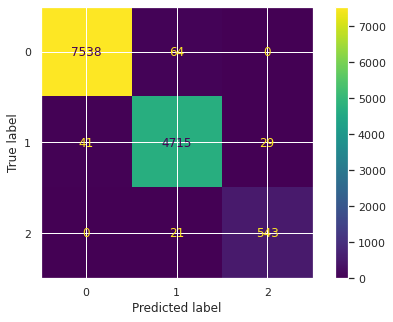

In [53]:
clf = get_stacking()

t0 = time.time()
model = make_pipeline(custom_transf,std_scale, pca, enn, clf)
model.fit(sample_train, label_train)
pred = model.predict(sample_val)
t1 = time.time()
print('Time required: ',t1-t0)
print(classification_report(label_val,pred))
sns.set(rc={'figure.figsize':(8,5)})
plot_confusion_matrix(model, sample_val, label_val) 
plt.show()

In [54]:
test_target = prep_test['carat_class']
test_data = prep_test.drop(labels = ['carat_class'],axis = 1)

t0 = time.time()
model = make_pipeline(custom_transf,std_scale, pca, enn, clf)
model.fit(data, target)
pred = model.predict(test_data)
t1 = time.time()
print('Time required: ',t1-t0)

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Time required:  221.10923719406128


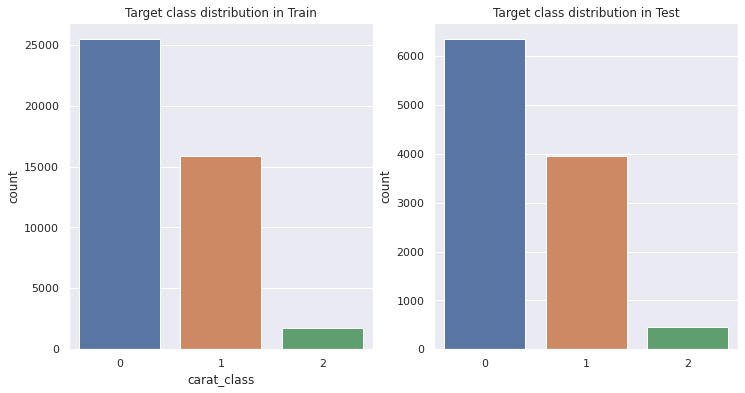

In [55]:
fig,ax = plt.subplots(1,2, figsize = (12,6))
sns.countplot(x= target , ax = ax[0]).set_title("Target class distribution in Train")
sns.countplot(x= pred , ax = ax[1]).set_title("Target class distribution in Test")
plt.show()